In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from matplotlib.ticker import FormatStrFormatter
import re
import os
from scipy.optimize import curve_fit
from matplotlib.gridspec import GridSpec
import math

In [2]:
file_path = 'Figure 6 and Table 1 (2024 ON).csv'
data = pd.read_csv(file_path)
print(data.to_string(index=False))

                       FITS_File           JD  Predicted_RA_deg  Predicted_DEC_deg  Detected  Centroid_X_px  Centroid_Y_px  Detected_RA_deg  Detected_DEC_deg  Uncertainty_px
015760_0000_2024_ON_REDUCED.fits 2.460559e+06        269.228500           5.079583      True     434.722959     305.827367       269.228465          5.079513             0.5
015760_0001_2024_ON_REDUCED.fits 2.460559e+06        269.228482           5.079505      True     434.491359     305.525411       269.228509          5.079453             0.5
015760_0002_2024_ON_REDUCED.fits 2.460559e+06        269.228464           5.079427      True     434.629576     305.928196       269.228469          5.079372             0.5
015760_0003_2024_ON_REDUCED.fits 2.460559e+06        269.228447           5.079355      True     435.014769     306.074333       269.228442          5.079320             0.5
015760_0004_2024_ON_REDUCED.fits 2.460559e+06        269.228429           5.079276      True     435.250559     306.545656       2

In [3]:
jd_adjusted = data['JD']
jd_binned_median1 = jd_adjusted - jd_adjusted.min()

ra_deg_adjusted_detected1 = data['Detected_RA_deg']

print(f"{'JD Adjusted':<25}{'RA Adjusted Detected':<25}")
print("=" * 75)

for jd, ra in zip(jd_binned_median1, ra_deg_adjusted_detected1):
    print(f"{jd:<25.10f}{ra:<25.10f}")

JD Adjusted              RA Adjusted Detected     
0.0000000000             269.2284646612           
0.0001504631             269.2285093632           
0.0003009262             269.2284693649           
0.0004398152             269.2284417758           
0.0005902783             269.2284395375           
0.0361458343             269.2256644918           
0.0362962973             269.2256404351           
0.0364467590             269.2256225845           
0.0365856481             269.2256340876           
0.0367361112             269.2256149949           
0.0532986112             269.2245030778           
0.0534490743             269.2244639526           
0.0535995374             269.2244555788           
0.0537384264             269.2244575694           
0.0538888890             269.2244371495           
0.0799421300             269.2228845936           
0.0800925931             269.2229171850           
0.0802314812             269.2228881224           
0.0803819452             269.22

In [4]:
mask = ~np.isnan(ra_deg_adjusted_detected1)

jd_binned_median = jd_binned_median1[mask]

ra_deg_adjusted_detected = ra_deg_adjusted_detected1[mask]

print(f"{'jd_binned_median':<25}{'ra_deg_adjusted_detected':<25}")
print("=" * 50)

for jd, ra in zip(jd_binned_median, ra_deg_adjusted_detected):
    print(f"{jd:<25.10f}{ra:<25.10f}")

jd_binned_median         ra_deg_adjusted_detected 
0.0000000000             269.2284646612           
0.0001504631             269.2285093632           
0.0003009262             269.2284693649           
0.0004398152             269.2284417758           
0.0005902783             269.2284395375           
0.0361458343             269.2256644918           
0.0362962973             269.2256404351           
0.0364467590             269.2256225845           
0.0365856481             269.2256340876           
0.0367361112             269.2256149949           
0.0532986112             269.2245030778           
0.0534490743             269.2244639526           
0.0535995374             269.2244555788           
0.0537384264             269.2244575694           
0.0538888890             269.2244371495           
0.0799421300             269.2228845936           
0.0800925931             269.2229171850           
0.0802314812             269.2228881224           
0.0803819452             269.22

In [5]:
#  Equation 5
def fit_function_linear(x, A, B, C, D):
    return A * np.sin(2 * np.pi * x + B) + C * x + D

params_sine, covariance_sine = curve_fit(fit_function_linear, jd_binned_median, ra_deg_adjusted_detected)
print(f"\033[1;32m Equation 1: sine +linear terms (Paramters):     {params_sine}\033[0m")

# Uncertainties in Equation 5
sine_uncertainties = np.sqrt(np.diag(covariance_sine))
print(f"\033[1;32m Equation 1: sine +linear terms (Uncertainities):{sine_uncertainties}\033[0m")

 Equation 1: sine +linear terms (Paramters):     [3.68147363e-02 9.74094964e+01 1.50647554e-01 2.69229230e+02]
 Equation 1: sine +linear terms (Uncertainities):[0.00074081 0.01269633 0.0052693  0.00045942]


In [6]:
amplitude_deg = params_sine[0]
amplitude_rad = math.radians(amplitude_deg)
print(f"\033[1;32mamplitude (rad):              {amplitude_rad}\033[0m")
 
amplitude_uncertainty_deg = sine_uncertainties[0]
amplitude_uncertainty_rad = math.radians(amplitude_uncertainty_deg)
print(f"\033[1;32mamplitude uncertianity (rad): {amplitude_uncertainty_rad}\033[0m")

amplitude (rad):              0.0006425383617026752
amplitude uncertianity (rad): 1.292948727511457e-05


In [7]:
earth_radius_km = 6371  

distance_km = earth_radius_km / amplitude_rad

distance_uncertainty_km = (earth_radius_km/amplitude_rad) * (amplitude_uncertainty_rad/abs(amplitude_rad))

print(f"\033[1;32mEquation 3: Distance_km: {abs(distance_km):.2f} ± {abs(distance_uncertainty_km):.2f}\033[0m")

Equation 3: Distance_km: 9915361.29 ± 199522.00


In [8]:
latitude_deg = 30.1732 
latitude_rad = math.radians(latitude_deg)
print("Latitude (rad):              ", latitude_rad)

Latitude (rad):               0.526621685862753


In [9]:
dec_deg = 5.079513 
dec_rad = math.radians(dec_deg)
print("DEC (rad):                   ", dec_rad)

DEC (rad):                    0.08865422624785474


In [10]:
asteroid_km = (distance_km * math.cos(latitude_rad)) / math.cos(dec_rad)

asteroid_uncertainty_km = asteroid_km * (distance_uncertainty_km / distance_km)

print(f"\033[1;32mEquation 4: Asteroid Distance (km):{abs(asteroid_km):.2f} ± {abs(asteroid_uncertainty_km):.2f}\033[0m")

Equation 4: Asteroid Distance (km):8605725.45 ± 173168.83


In [15]:
km_to_au = 149597870.7

asteroid_dist_au = asteroid_km / km_to_au

asteroid_dist_uncertainty_au = asteroid_uncertainty_km / km_to_au

print(f"\033[1;32mAsteroid Distance (AU):{abs(asteroid_dist_au):.7f} ± {abs(asteroid_dist_uncertainty_au):.7f}\033[0m")

Asteroid Distance (AU):0.0575257 ± 0.0011576


In [12]:
true_distance = 0.057979
print(f"\033[1;32mNASA JPL Horizons True distance (AU): {true_distance}\033[0m")

NASA JPL Horizons True distance (AU): 0.057979


In [13]:
if asteroid_dist_au == 0 or true_distance == 0:
    print("\033[1;31mError: One of the values is zero, cannot compute percentage difference.\033[0m")
else:
    percentage_difference = abs(abs(asteroid_dist_au) - abs(true_distance)) / ((abs(asteroid_dist_au) + abs(true_distance)) / 2) * 100
    print(f"\033[1;32mAsteroid Distance Difference between True and Predicted: {percentage_difference:.6f}%\033[0m")

Asteroid Distance Difference between True and Predicted: 0.784866%


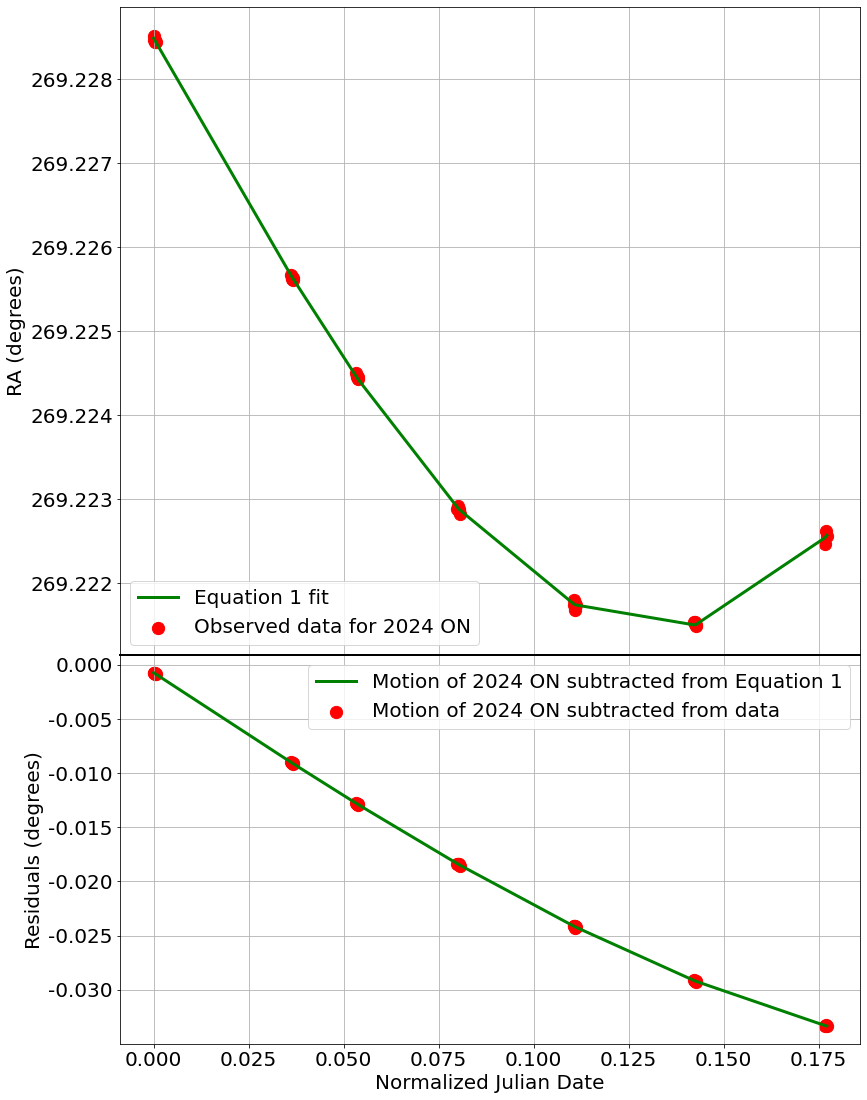

In [14]:
fig = plt.figure(figsize=(12.1, 18))
gs = GridSpec(3, 1, height_ratios=[10, 6, 1], figure=fig)

# Subplot 1: 
ax1 = fig.add_subplot(gs[0, 0])

ax1.scatter(jd_binned_median, ra_deg_adjusted_detected, color='red', label = 'Observed data for 2024 ON', s = 150)
ax1.plot(jd_binned_median, fit_function_linear(jd_binned_median, *params_sine), color='green', label = 'Equation 1 fit', linewidth = 3)

ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.set_ylabel("RA (degrees)", fontsize=20)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax1.set_xticklabels([])
ax1.legend(fontsize=20, loc='lower left')
ax1.grid()

# Subplot 2: 
ax2 = fig.add_subplot(gs[1, 0])

ax2.plot(jd_binned_median, 
         fit_function_linear(jd_binned_median, *params_sine) - (params_sine[2]*jd_binned_median + params_sine[3]), 
         color = 'green', label = 'Motion of 2024 ON subtracted from Equation 1', linewidth = 3)
ax2.scatter(jd_binned_median, ra_deg_adjusted_detected - (params_sine[2]*jd_binned_median + params_sine[3]), 
            color = 'red', label = 'Motion of 2024 ON subtracted from data', s = 150)

ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_xlabel("Normalized Julian Date", fontsize=20)
ax2.set_ylabel("Residuals (degrees)", fontsize=20) 
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.legend(fontsize=20, loc='upper right')
ax2.grid()

plt.subplots_adjust(hspace=0)
plt.gcf().axes[0].spines['bottom'].set_linewidth(2)
plt.gcf().axes[1].spines['top'].set_linewidth(2)

plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.1, hspace=0)
plt.savefig("Figure 6.png", format="png", dpi=300, bbox_inches="tight", facecolor='white')

plt.show()